In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from os import path
import itertools
import requests
from bs4 import BeautifulSoup
from io import StringIO
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import ScalarFormatter, LogFormatter, LogFormatterExponent, LogFormatterMathtext

In [2]:
fontP = FontProperties()
fontP.set_size('small')

In [3]:
%matplotlib inline

In [4]:
def get_word(word):
    old_word = word
    word = word.strip()
    word = word.lower()
    word = word.replace(" ", "_")
    first_four = "/".join(word[:5])
    while True:
        request = requests.get("https://projects.fivethirtyeight.com/reddit-data/{}/{}.csv".format(first_four, word))
        if request.status_code == requests.codes.NOT_FOUND:
            print("Word: '{}' was not found.".format(old_word))
            return None

        if request.status_code == requests.codes.ok:
          return pd.read_csv(StringIO(request.text))
        else:
          print("We could not get the word '{}'\nsleeping for 10s ...".format(old_word))
          sleep(10)

def get_words(words):
    frames = [get_word(words[0])]
    for word in words[1:]:
        df = get_word(word)
        if df is not None:
          frames.append(df.ngram_fraction)
        else:
            frames.append(df)
    valid_words = []
    valid_frames = []
    for i, frame in enumerate(frames):
        if frame is not None:
            valid_words.append(words[i])
            valid_frames.append(frames[i])
    if not valid_frames:
        print("None of the words requested were found.")
        return None
    if len(valid_frames) > 1:
      df = pd.concat(frames, axis=1)
    else:
      df = frames[0]
    df.columns = ["date"] + [x.strip().replace(" ", "_") for x in valid_words]
    df.set_index("date", inplace=True)
    return df

In [5]:
data = get_word("African American")
data.tail()

,date,ngram_fraction
2873,2015-08-27,0.000003
2874,2015-08-28,0.000002
2875,2015-08-29,0.000003
2876,2015-08-30,0.000003
2877,2015-08-31,0.000003


In [6]:
data = get_word("meh")
data.tail()

,date,ngram_fraction
2873,2015-08-27,0.000030
2874,2015-08-28,0.000031
2875,2015-08-29,0.000031
2876,2015-08-30,0.000030
2877,2015-08-31,0.000031


In [7]:
data = get_words(["monocultural", "mono-cultural", "mono cultural", "monoculturals", "mono-culturals", "mono culturals",
                  "biracial", "bi-racial", "bi racial", "biracials", "bi-racials", "bi racials",
                 "interracial", "inter-racial", "inter racial", "interracials", "inter-racials", "inter racials",
                 "multiracial", "multi-racial", "multi racial", "multiracials", "multi-racials", "multi racials",
                 "multiethnic", "multi-ethnic", "multi ethnic", "multiethnics", "multi-ethnics", "multi ethnics",
                 "multicultural", "multi-cultural", "multi cultural", "multiculturals", "multi-culturals", "multi culturals",
                 "multiculturalism", "multi-culturalism", "multi culturalism", "multiculturalisms",  "multi-culturalisms", "multi culturalisms"])

Word: 'mono-cultural' was not found.
Word: 'mono cultural' was not found.
Word: 'monoculturals' was not found.
Word: 'mono-culturals' was not found.
Word: 'mono culturals' was not found.
Word: 'bi racial' was not found.
Word: 'biracials' was not found.
Word: 'bi-racials' was not found.
Word: 'bi racials' was not found.
Word: 'inter racial' was not found.
Word: 'interracials' was not found.
Word: 'inter-racials' was not found.
Word: 'inter racials' was not found.
Word: 'multi-racial' was not found.
Word: 'multi racial' was not found.
Word: 'multiracials' was not found.
Word: 'multi-racials' was not found.
Word: 'multi racials' was not found.
Word: 'multi ethnic' was not found.
Word: 'multiethnics' was not found.
Word: 'multi-ethnics' was not found.
Word: 'multi ethnics' was not found.
Word: 'multi cultural' was not found.
Word: 'multiculturals' was not found.
Word: 'multi-culturals' was not found.
Word: 'multi culturals' was not found.
Word: 'multi culturalism' was not found.
Word: 'mul

In [26]:
data = get_words(["monocultural",
                  "biracial", "bi-racial",
                  "interracial",
                 "multiracial",
                 "multiethnic", "multi-ethnic",
                 "multicultural", "multi-cultural",
                 "multiculturalism", "multi-culturalism"])

In [8]:
data["biracial"] = data["biracial"] + data["bi-racial"]

In [9]:
data["multiethnic"] = data["multiethnic"] + data["multi-ethnic"]

In [10]:
data["multicultural"] = data["multicultural"] + data["multi-cultural"]

In [11]:
data["multiculturalism"] = data["multiculturalism"] + data["multi-culturalism"]

In [30]:
data.index = pd.to_datetime(data.index, format="%Y-%m-%d")

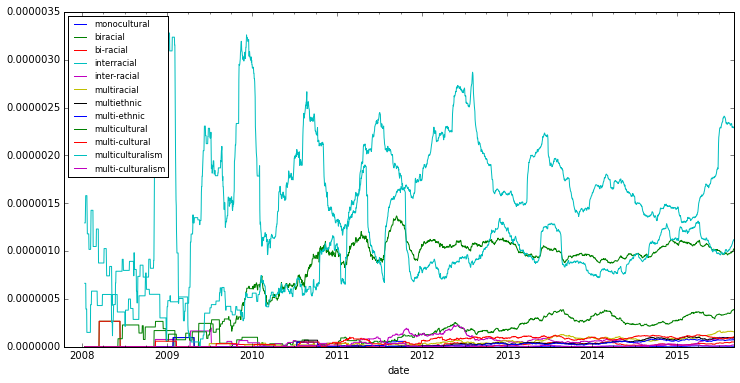

In [31]:
days_to_average_over = 90
smoothed_data = data.rolling(window=days_to_average_over).mean()
axis = smoothed_data.plot()
fig = plt.gcf()
fig.set_size_inches((12,6))
_ = axis.legend(prop=fontP, loc="best")

In [40]:
def plot(dataframe, words):
    #markers = itertools.cycle(['s', 'D', '*', 'p', 'h', 'o', '+', 'd'])
    line_types = itertools.cycle(['-', '--', '-.'])
    df = dataframe[words]
    days_to_average_over = 90
    smoothed_data = df.rolling(window=days_to_average_over).mean()
    plt.figure(figsize=(16,6))

    for i,word in enumerate(words):
        plt.plot(smoothed_data.index, smoothed_data[word], next(line_types), 
                 linewidth=3,color=str(i/float(len(words))))
    axis_1 = plt.gca()

    axis_1.set_yscale('log') # You can disable
    axis_1.set_ylim(ymin=1e-6,ymax=5e-6) # You can disable
    axis_1.yaxis.set_major_formatter(LogFormatterMathtext())  # You can disable
    #axis_1.grid(True)

    font = {'family': "Times New Roman",
            'color': 'black',
           'size': 12}
    axis_1.set_ylabel("Percentage of N-Grams (%)", font)
    axis_1.set_xlabel("Year", font)
    #axis_1.yaxis.set_major_formatter(FixedOrderFormatter(-3)) # You can enable
    plt.legend(words, loc=2)

In [ ]:
#def inline_labels():
 #   plt.clf()
    #x = np.linspace(0, 1, 101)
   #y1 = np.sin(x * np.pi / 2)
    #y2 = np.cos(x * np.pi / 2)
    #plt.plot(x, y1, label='sin')
    #plt.plot(x, y2, label='cos')
    #plt.text(0.08, 0.2, 'sin')
    #plt.text(0.9, 0.2, 'cos')


//anaconda/lib/python3.5/site-packages/matplotlib/scale.py:100: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


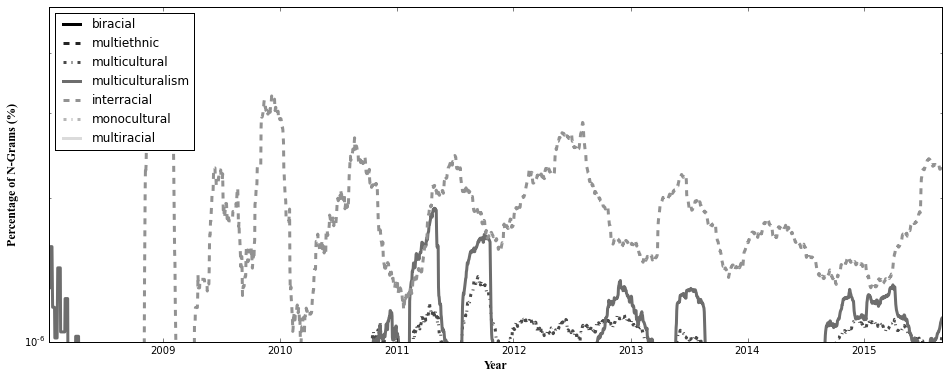

In [42]:
words = ["biracial", "multiethnic", "multicultural", "multiculturalism",
         "interracial", "monocultural", "multiracial"]
plot(data,words)